In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import seaborn as sn
from TradingDataFrame import TradingDataFrame
from strategy import Strategy

In [2]:
import requests
start_date = datetime(2018, 2, 1)
fng_index = requests.get(f"https://api.alternative.me/fng/?limit={(datetime.today() - start_date).days}").json()

In [3]:
df_fng_index = pd.DataFrame(fng_index['data'])
df_fng_index = df_fng_index.rename(columns={'timestamp': 'Open Time', 'value': 'FNG Index'})
df_fng_index['Open Time'] = pd.to_datetime(df_fng_index['Open Time'], unit='s')
df_fng_index['FNG Index'] = pd.to_numeric(df_fng_index['FNG Index'])
df_fng_index = df_fng_index.set_index('Open Time').sort_index()
df_fng_index

,FNG Index,value_classification,time_until_update
Open Time,,,
2018-02-01,30,Fear,NaN
2018-02-02,15,Extreme Fear,NaN
2018-02-03,40,Fear,NaN
2018-02-04,24,Extreme Fear,NaN
2018-02-05,11,Extreme Fear,NaN
...,...,...,...
2023-03-08,50,Neutral,NaN
2023-03-09,44,Fear,NaN
2023-03-10,34,Fear,NaN


In [4]:
# Binance packages

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.exceptions import BinanceAPIException

stuffs = ''
api_key = ''
api_secret = ''

client = Client(api_key, api_secret)
prices = pd.DataFrame(client.get_all_tickers())

start_date_str = str(start_date.day) + ' ' + calendar.month_abbr[start_date.month] + ' ' + str(start_date.year)
today_date = str(datetime.today().day+1) + ' ' + calendar.month_abbr[datetime.today().month] + ' ' + str(datetime.today().year)

# Extract BTCUSDT data

klines = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1DAY, start_date_str, today_date)
klines_cols = [
    'Open Time',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Close time',
    'Quote asset volume',
    'Number of trades',
    'Taker buy base asset volume',
    'Taker buy quote asset volume',
    'Ignore']

# Setup df

df = pd.DataFrame(klines, columns=klines_cols)
df = df[['Open Time', 'Open']].copy()
df.drop_duplicates(inplace=True)

In [5]:
tdf = TradingDataFrame(df, time_col=df.columns[0], price_cols=df.columns[1:], time_unit='ms')

In [6]:
checking = pd.merge(tdf.data, df_fng_index[['FNG Index']], left_index=True, right_index=True, how='outer')

In [7]:
dates_missing = checking[checking.isna().any(axis=1)]
df_fng_index = pd.concat([df_fng_index, dates_missing[['FNG Index']]])
df_fng_index = df_fng_index.interpolate()
df_fng_index = df_fng_index.sort_index()

In [8]:
criteria_df = df_fng_index[['FNG Index']].iloc[1:,:].copy()
tdf.set_criteria_df(criteria_df)

Strategy applied!
# of trades: 16
Sharpe ratio: -1.73


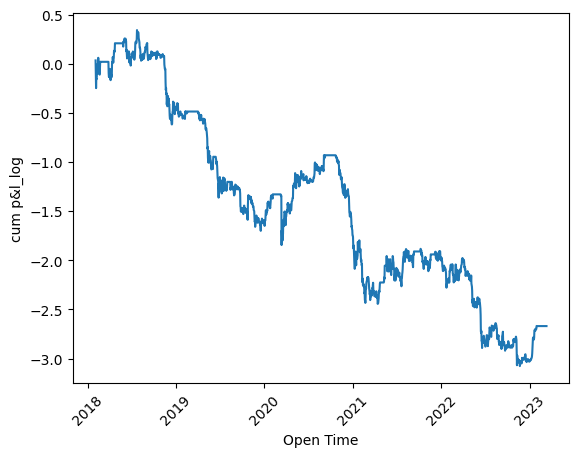

In [18]:
fng_strat = Strategy()
fng_strat.set_strategy(
    long_entry=['<', 20],
    long_exit=['>', 60],
    short_entry=['>', 70],
    short_exit=['<', 40]
)
fng_strat.backtest(tdf, trading_fee=0.001, plot_returns='log')

In [12]:
fng_strat.df.tail(20)

,Open,Open_next_day,Open_pos_long,Open_pos_short,no_of_trades,trading fees,daily p&l,daily p&l after fees,cum p&l_log,cum p&l_simple
Open Time,,,,,,,,,,
2023-02-20,-0.014703,0.023266,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
2023-02-21,0.023266,-0.015954,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
2023-02-22,-0.015954,-0.011040,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
2023-02-23,-0.011040,-0.010058,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
2023-02-24,-0.010058,-0.032094,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
2023-02-25,-0.032094,-0.001164,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
2023-02-26,-0.001164,0.017031,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
2023-02-27,0.017031,-0.002668,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
2023-02-28,-0.002668,-0.015033,0.0,0.0,0.0,0.0,0.0,0.0,-2.756722,-0.9365
